In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from PIL import Image


def plot_accuracy_bar(csv_path, model_name, collect_results=True):
    df = pd.read_csv(csv_path)
    grouped = df.groupby('actual_specialty')
    results = []
    for specialty, group in grouped:
        total = len(group)
        correct = (group['actual_specialty'] == group['predicted_specialty']).sum()
        accuracy = correct / total if total > 0 else 0
        results.append({
            'Model': model_name,
            'Specialty': specialty,
            'Accuracy': accuracy,
            'Num_Cases': total
        })
    # For individual plots (optional)
    results_df = pd.DataFrame(results)
    overall_correct = (df['actual_specialty'] == df['predicted_specialty']).sum()
    overall_total = len(df)
    overall_accuracy = overall_correct / overall_total if overall_total > 0 else 0
    # Save per-model plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar([f"{x['Specialty']}\nN={x['Num_Cases']}" for x in results], [x['Accuracy'] for x in results])
    for bar, acc in zip(bars, [x['Accuracy'] for x in results]):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{acc:.1%}",
                 ha='center', va='bottom', fontsize=9)
    plt.xticks(rotation=90, ha='center')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy per Actual Specialty - {model_name} (Overall: {overall_accuracy:.1%})')
    plt.ylim(0, 1.1)
    plt.tight_layout()
    png_path = os.path.join(os.path.dirname(csv_path), f'accuracy_per_specialty_{model_name}.png')
    plt.savefig(png_path)
    plt.close()
    # print(f"Saved plot to {png_path}")
    # Collect results for summary
    if collect_results:
        return results
    return None

parent_dir = './ai-triage'  # Or set to your parent directory
all_results = []

for subfolder in tqdm(os.listdir(parent_dir), desc="Processing"):
    subfolder_path = os.path.join(parent_dir, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    for file in os.listdir(subfolder_path):
        if file.startswith('triage_pred_') and file.endswith('.csv'):
            model_name = file.replace('triage_pred_', '').replace('.csv', '')
            csv_path = os.path.join(subfolder_path, file)
            # print(f"Processing {csv_path}")
            results = plot_accuracy_bar(csv_path, model_name)
            if results is not None:
                all_results.extend(results)


import matplotlib.pyplot as plt

# Aggregate into DataFrame
summary_df = pd.DataFrame(all_results)

# Ensure all models and specialties are present
all_models = sorted(summary_df['Model'].unique())
all_specialties = sorted(summary_df['Specialty'].unique())

parent_save_dir = parent_dir  # Where to save specialty-wise plots

for specialty in all_specialties:
    # Filter for this specialty
    subdf = summary_df[summary_df['Specialty'] == specialty]
    # Sometimes not all models have all specialties; merge with full model list for completeness
    acc_map = {row['Model']: row['Accuracy'] for _, row in subdf.iterrows()}
    acc_list = [acc_map.get(model, 0) for model in all_models]  # 0 or np.nan for missing

    # Bar plot
    plt.figure(figsize=(max(6, len(all_models)*0.7), 5))
    bars = plt.bar(all_models, acc_list)
    for bar, acc in zip(bars, acc_list):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f"{acc:.1%}", 
                 ha='center', va='bottom', fontsize=10)
    plt.ylim(0, 1.05)
    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.title(f'Accuracy on Specialty: {specialty}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    save_path = os.path.join(parent_save_dir, f"specialty_accuracy_{specialty.replace('/', '_').replace(' ', '')}.png")
    plt.savefig(save_path)
    plt.close()
    # print(f"Saved plot for {specialty}: {save_path}")




Processing:   0%|          | 0/17 [00:00<?, ?it/s]

Processing: 100%|██████████| 17/17 [00:02<00:00,  6.56it/s]


Saved plot for allergy / immunology: ./ai-triage/specialty_accuracy_allergy_immunology.png
Saved plot for cardiovascular / pulmonary: ./ai-triage/specialty_accuracy_cardiovascular_pulmonary.png
Saved plot for dermatology: ./ai-triage/specialty_accuracy_dermatology.png
Saved plot for endocrinology: ./ai-triage/specialty_accuracy_endocrinology.png
Saved plot for ent - otolaryngology: ./ai-triage/specialty_accuracy_ent-otolaryngology.png
Saved plot for gastroenterology: ./ai-triage/specialty_accuracy_gastroenterology.png
Saved plot for ophthalmology: ./ai-triage/specialty_accuracy_ophthalmology.png
Saved plot for orthopedic: ./ai-triage/specialty_accuracy_orthopedic.png
Saved plot for psychiatry / psychology: ./ai-triage/specialty_accuracy_psychiatry_psychology.png
Saved plot for rheumatology: ./ai-triage/specialty_accuracy_rheumatology.png
Saved plot for sleep medicine: ./ai-triage/specialty_accuracy_sleepmedicine.png
Saved plot for urology: ./ai-triage/specialty_accuracy_urology.png


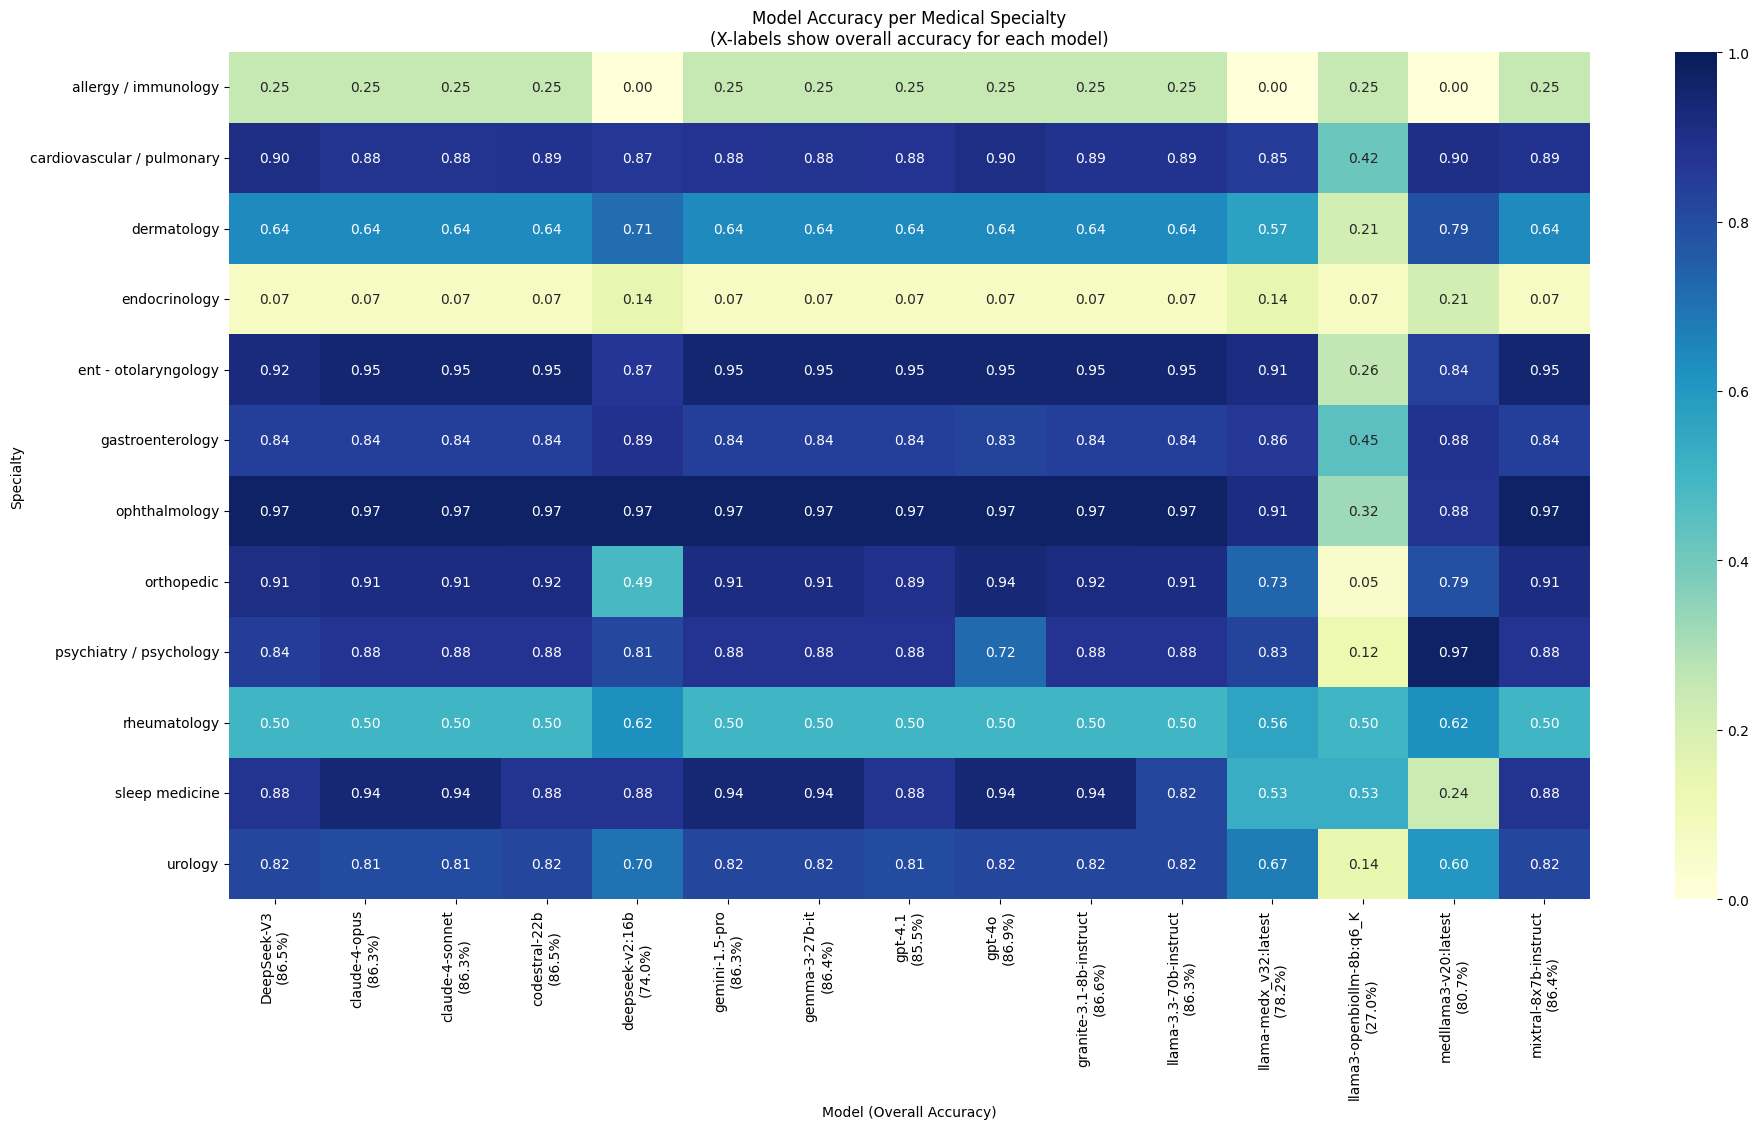

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
# Assuming all_results is a list of dicts as in your setup
import pandas as pd

results_df = pd.DataFrame(all_results)

# Read all original CSVs again to get actual per-sample correctness (optional if you keep per-sample info)
# But here, if you already have all_results: Model, Specialty, Accuracy, Num_Cases

# Group by model and sum correct/total
results_df['Num_Correct'] = (results_df['Accuracy'] * results_df['Num_Cases']).round(0).astype(int)
model_acc = (
    results_df.groupby('Model').agg(
        total_correct=('Num_Correct', 'sum'),
        total_cases=('Num_Cases', 'sum')
    )
)
model_acc['Overall_Accuracy'] = model_acc['total_correct'] / model_acc['total_cases']

# Build the label dict
model_labels = {
    model: f"{model}\n({acc:.1%})"
    for model, acc in model_acc['Overall_Accuracy'].items()
}



# Use the *aggregated* DataFrame to build the pivot table for the heatmap
agg_df = results_df.groupby(['Specialty', 'Model'], as_index=False)['Accuracy'].mean()
pivot_df = agg_df.pivot(index='Specialty', columns='Model', values='Accuracy')

# Reorder columns to match label order
pivot_df = pivot_df[[m for m in model_labels]]

# Set new column labels (model name + overall acc)
pivot_df.columns = [model_labels[m] for m in pivot_df.columns]

plt.figure(figsize=(len(pivot_df.columns)*1.3, len(pivot_df)*0.7 + 3))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap='YlGnBu', vmin=0, vmax=1)
plt.title("Model Accuracy per Medical Specialty\n(X-labels show overall accuracy for each model)")
plt.ylabel('Specialty')
plt.xlabel('Model (Overall Accuracy)')
plt.tight_layout()
plt.savefig('all_specialties_accuracy_heatmap.png')
plt.show()

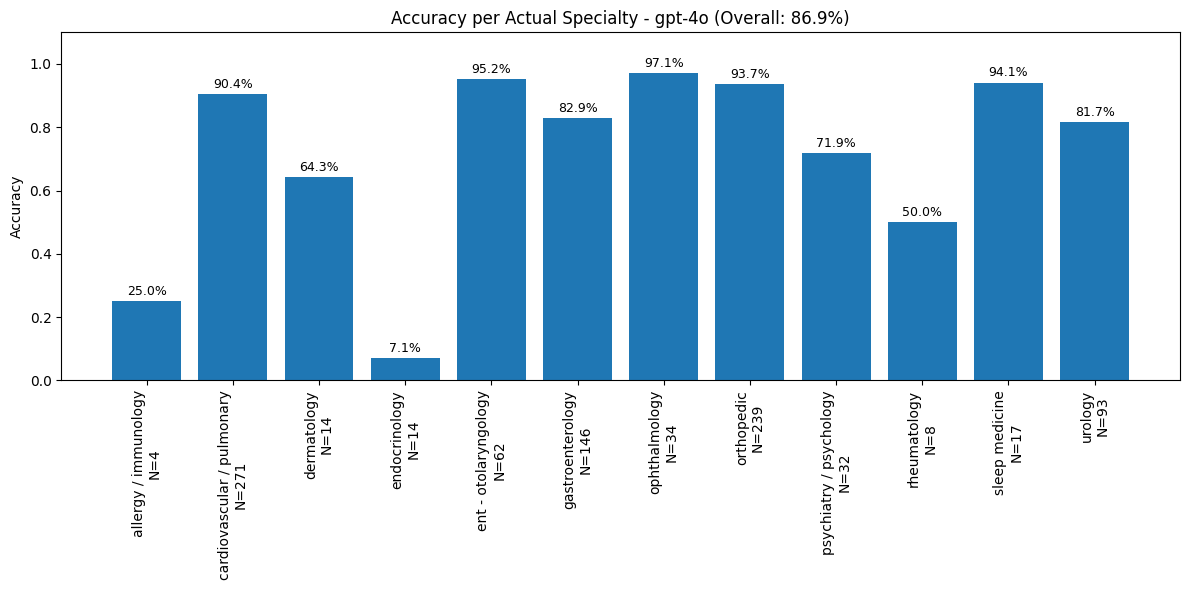

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
model_name = "gpt-4o"
df = pd.read_csv(f'****gpt-4o/triage_pred_gpt-4o.csv')

# Group by actual_specialty
grouped = df.groupby('actual_specialty')

# Compute accuracy and count per specialty
results = []
for specialty, group in grouped:
    total = len(group)
    correct = (group['actual_specialty'] == group['predicted_specialty']).sum()
    accuracy = correct / total
    results.append({
        'Specialty': f"{specialty}\nN={total}",  # newline for multi-line label
        'Accuracy': round(accuracy, 4),
        'Num_Cases': total
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# Calculate overall accuracy
overall_correct = (df['actual_specialty'] == df['predicted_specialty']).sum()
overall_total = len(df)
overall_accuracy = overall_correct / overall_total

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(results_df['Specialty'], results_df['Accuracy'])

# Add accuracy label on top of bars
for bar, acc in zip(bars, results_df['Accuracy']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{acc:.1%}",
             ha='center', va='bottom', fontsize=9)

# Final touches
plt.xticks(rotation=90, ha='center')  # Now centered since labels are multiline
plt.ylabel('Accuracy')
plt.title(f'Accuracy per Actual Specialty - {model_name} (Overall: {overall_accuracy:.1%})')
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()


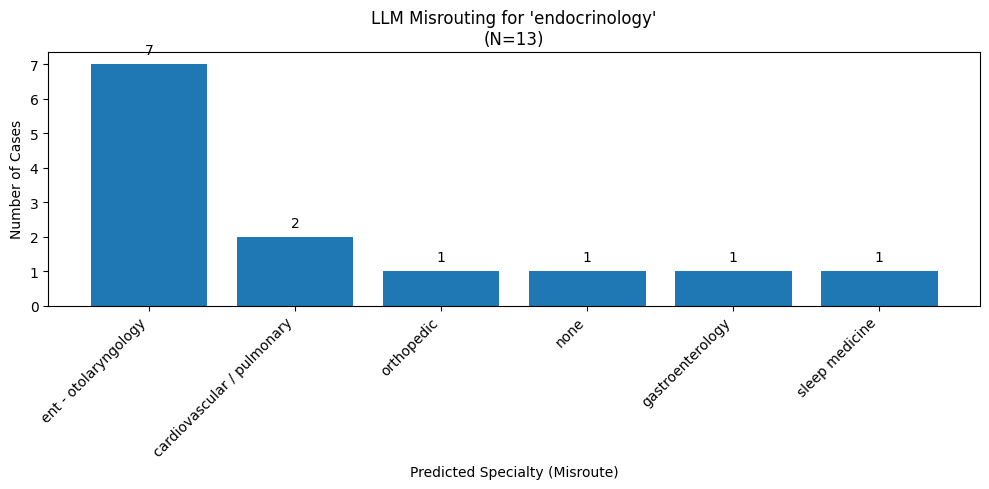

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_misroute_distribution(csv_path, specialty):
    # Load CSV
    df = pd.read_csv(csv_path)
    
    # Filter rows for selected specialty where prediction is wrong
    wrong = df[(df['actual_specialty'] == specialty) & (df['predicted_specialty'] != specialty)]
    
    if wrong.empty:
        print(f"No misclassifications found for specialty: {specialty}")
        return

    # Count each predicted_specialty (i.e., the misroutes)
    misroute_counts = wrong['predicted_specialty'].value_counts().sort_values(ascending=False)
    
    # Bar plot
    plt.figure(figsize=(10, 5))
    bars = plt.bar(misroute_counts.index, misroute_counts.values)
    
    # Add count on top of bars
    for bar, count in zip(bars, misroute_counts.values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.2, str(count),
                 ha='center', va='bottom', fontsize=10)
    
    plt.title(f"LLM Misrouting for '{specialty}'\n(N={len(wrong)})")
    plt.ylabel('Number of Cases')
    plt.xlabel('Predicted Specialty (Misroute)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage:
csv_path = '****gpt-4o/triage_pred_gpt-4o.csv'
specialty = "endocrinology"  # Change this to whatever you want to analyze
plot_misroute_distribution(csv_path, specialty)


In [9]:
import pandas as pd
import os

def extract_misrouted_with_description(triage_csv, layman_csv, target_specialty, output_csv):
    # Read both CSVs
    triage_df = pd.read_csv(triage_csv)
    layman_df = pd.read_csv(layman_csv, usecols=['row_id', 'original_description'])
    # Build row_id to original_description mapping
    id2desc = layman_df.set_index('row_id')['original_description'].to_dict()
    # Filter misrouted rows for target specialty
    mask = (triage_df['actual_specialty'] == target_specialty) & (triage_df['predicted_specialty'] != target_specialty)
    misrouted_df = triage_df.loc[mask].copy()
    # Add new column from mapping
    misrouted_df['original_description'] = misrouted_df['row_id'].map(id2desc)
    # Make output directory if needed
    output_dir = os.path.dirname(output_csv)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # Write result
    misrouted_df.to_csv(output_csv, index=False)
    print(f"Saved {len(misrouted_df)} misrouted cases for '{target_specialty}' to {output_csv}")

# Example usage:
folder     = '****gpt-4o'
triage_csv = f'{folder}/triage_pred_gpt-4o.csv'
layman_csv = '../datasets/mtsamples_layman_v3.csv'
target_specialty = "endocrinology"
output_csv = f'{folder}/misrouted_endocrinology.csv'
extract_misrouted_with_description(triage_csv, layman_csv, target_specialty, output_csv)


Saved 13 misrouted cases for 'endocrinology' to ****gpt-4o/misrouted_endocrinology.csv
